# Initialize


In [4]:
expt_path = 'C:\\_Data\\Lairon\\2025_06_02\\'
cfg_file='lairon2.yml'
ip = '192.168.137.1'
max_t1 = 150

## Set up new config 
Set to variables to True when setting up a new experiment. 

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

There are several elements that you may want to customize based on your readout parameters and coherence times. Check readme file config_init_config_manual.md

In [5]:
# Set to false if you aren't creating a new one
new_config = False
new_folder = False

nqubits = 3
rfsoc_alias = 'chatot'
t1_guess = 30 

import os
import slab_qick_calib.config as config

configs_dir = os.path.join(os.getcwd(),'../', 'configs')

cfg_file_path = os.path.join(configs_dir, cfg_file)
images_dir = os.path.join(expt_path, 'images')
summary_dir = os.path.join(images_dir, 'summary')

if new_config or new_folder:


    if new_config:
        config.init_config(cfg_file_path, nqubits, type='full', aliases=rfsoc_alias, t1=t1_guess)

    if not os.path.exists(expt_path):
        os.makedirs(expt_path)
        os.mkdir(images_dir)
        os.mkdir(summary_dir)

print('Data will be stored in', expt_path)

Data will be stored in C:\_Data\Lairon\2025_06_02\


## Connect to RFSoC
Before running first cell, make sure a nameserver is running on the network, the Qick board is connected to it, and the ip address listed below matches that of the nameserver. 

You just need to run the first cell, then should be able to run any other cell in whatever order. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qick import QickConfig
import sys 
sys.path.append('../')
from slab_qick_calib.exp_handling.instrumentmanager import InstrumentManager
import slab_qick_calib.experiments as meas
from slab_qick_calib.calib import qubit_tuning, tuneup
from slab_qick_calib import handy
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

# Set color palette and font size
handy.config_figs()

# Results config file
cfg_path = os.path.join(os.getcwd(),'..', 'configs', cfg_file)
#cfg_path = os.path.join(configs_dir, cfg_file)
auto_cfg = config.load(cfg_path)

# Connect to instruments
im = InstrumentManager(ns_address=ip)
print(im)
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)

cfg_dict = {'soc': soc, 'expt_path': expt_path, 'cfg_file': cfg_path, 'im': im}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'Pyro.NameServer': <Pyro4.core.Proxy at 0x2363d559630; not connected; for PYRO:Pyro.NameServer@192.168.137.1:9090>, 'chatot': <Pyro4.core.Proxy at 0x2363d55aef0; not connected; for PYRO:obj_73f166b0347646ba8948a3bf1b2e9dc3@192.168.137.104:38119>}
QICK running on ZCU216, software version 0.2.334

Firmware configuration (built Mon Mar 31 16:32:04 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 Msps, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 Msps, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1

## How to update config (you can also just edit yml directly)

In [7]:
# #                                          param   value                        qubit #
# auto_cfg = config.update_readout(cfg_path, 'lamb', 5, qi)
# auto_cfg = config.update_qubit(cfg_path, 'f_ge', 5700, qi)

# # For multiple levels of nesting: 
# auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), 0.2, qi)


In general, all scans will be interacted with either by running default, or giving arguments from params dict. 
You can run scans on list of different qubits or just one by adding first couple lines of each cell. 
Flag of update is used to decide if to set new config vals based on output of scan (if the fit looks good)

## Check QICK issues

### Check mirror frequencies on qubit

In [ ]:
import qick_check

qick_check.check_freqs(0, cfg_dict)

### Check mirror frequencies from resonators

In [ ]:
qick_check.check_resonances(cfg_dict)

### Check sampling rates and minimum point spacing

In [ ]:
cfg_dict['soc']._get_ch_cfg(ro_ch=0)['f_dds']/2
cfg_dict['soc'].cycles2us(1)

### Make sure you're not near the nyquist frequency of the ADC

In [ ]:
import qick_check
qick_check.check_adc(cfg_dict)

## Check potential sampling rates

In [ ]:
#soc.round_sample_rate(tiletype='dac', tile=0, fs_target=5000)
soc.valid_sample_rates(tiletype='dac', tile=0)

# Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

 Use this to set trig_offset in config file

In [ ]:
qubit_list = np.arange(3)
qubit_list = [0]
for qi in qubit_list:  
        tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi)

        # Set frequency of choice and readout length up to 13 us
        #tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi,params={'readout_length':13})#,params={'frequency':fi})
       

In [ ]:
tof2d = meas.ToF2D(cfg_dict=cfg_dict, qi=qi, params={'expts_count':10000, 'readout_length': 13})

In [ ]:
tof2d = meas.ToF2D(cfg_dict=cfg_dict, qi=qi, params={'expts_count':10000, 'readout_length': 13,'check_e':True})

## Set trig_offset to point where signal has appeared, usually around 500 ns


In [ ]:
qubit_list=np.arange(10)
for qi in qubit_list: 
    auto_cfg = config.update_readout(cfg_path, 'trig_offset', 0.65, qi)

# Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

## Coarse 

This will perform peak finding

In [ ]:
#rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=6000, span=800, reps=2000, npts=5000)
qi=0
rspecc = meas.ResSpec(cfg_dict, qi=qi, style='coarse', params={'start':4600, 'span':3000, 'soft_avgs':1, 'reps':200, 'gain':0.05, 'expts':10000})
res_values = rspecc.data['coarse_peaks']

Change prom (prominence value) to adjust how to find the peaks

In [ ]:
rspecc.analyze(peaks=True, debug=True, fit=False, prom=0.5)
rspecc.display(peaks=True, fit=False)
res_values = rspecc.data['coarse_peaks']

In [ ]:
res_values

In [ ]:
auto_cfg = config.load(cfg_path)
auto_cfg.device.readout.frequency[0:10]

Can delete values from res_values if they don't seem to be real res_values. 

In [ ]:
res_values = np.delete(res_values, 8)

## Fine

This will fit the resonance amplitude

In [ ]:
# Just run one  
update=True

qubit_list = np.arange(3)
#qubit_list=[0]

for qi in qubit_list:    
    #Used for initial finding of resonance 
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'center':res_values[qi]})

    # Manually set the span and gain 
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'gain':0.03})

    # Fully automated, using previous fit to kappa tp set s[am]
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':'kappa'})
    if update: rspec.update(cfg_dict['cfg_file'])

#plot will appear weird first because it plots the resonator frequency in the config on the same plot

## Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

In [ ]:
update=True

qubit_list = np.arange(3)
qubit_list=[0]

d=[]
for qi in qubit_list:
    #rpowspec=meas.ResSpecPower(cfg_dict, qi=qi)
    rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'rng':300,'max_gain':1, 'span':12,"f_off":1,'expts_gain':30})
    d.append(rpowspec)
    if update:
        auto_cfg = config.update_readout(cfg_path, 'lamb', rpowspec.data['lamb_shift'], qi)


In [ ]:
rpowspec.print()

In [ ]:
auto_cfg = config.load(cfg_path)
horz_line = auto_cfg.device.readout.gain
handy.plot_many(d, title='Resonator Power', save_path=cfg_dict['expt_path'], chan='amps', yax='log', norm=True, horz_line=horz_line)

### Save gain values 

In [ ]:
# assign the resonator gain to the results config file
gain_values = [0.1,0.01]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

# Qubit Spectroscopy

## Find qubits

More automated, best to use once you're confident of qubit location and just refinding it 

In [ ]:
qubit_list = np.arange(3)
qubit_list= [1,2]

bad_qubits=[]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium')
    if not status:
        bad_qubits.append(qi)

## General search, specify width 

fine, medium, coarse, huge (will change scan width and power)

Uses config values of low_gain (gain to use for finest scan), which sets overall gain for device and spec_gain (set indepedently for each qubit) to decide how much power to apply

In [ ]:
update=True

#qubit_list = np.arange(5)
qubit_list = [1]

for qi in qubit_list: 
    # Default, just specifiy style 
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse')

    # Different examples of params you might give; frequency can be specified as start and span or if no start given, center is f_ge from config
#qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'length':100})
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params={'span':300,'expts':1000,'gain':1,'reps':800})
    if update and qspec.status: 
        auto_cfg = config.update_qubit(cfg_path, 'f_ge', qspec.data["best_fit"][2], qi)
        auto_cfg = config.update_qubit(cfg_path, 'kappa',2*qspec.data["best_fit"][3], qi)
    elif update:
        print(f'Bad qubit! qi={qi}')

## Stark (not tested yet)

Unexpected parameters found in params: {'stark_freq'}


  0%|          | 0/600000 [00:00<?, ?it/s]

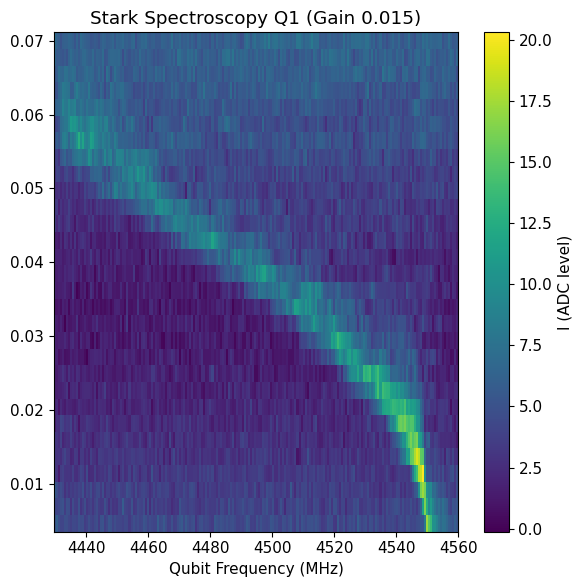

In [ ]:
qi=1
qspec=meas.StarkSpec(cfg_dict, qi=qi, style='medium', params={'df_stark':0, 'max_stark_gain':0.07, 'df':-55,'span':130, 'stark_expts':50,'stark_rng':50})

In [ ]:
Delta = auto_cfg.device.readout.frequency[qi]-auto_cfg.device.qubit.f_ge[qi]+4600

In [ ]:
from scipy.optimize import curve_fit

f = [qspec.data['fit_avgi'][i][2] for i in range(len(qspec.data['fit_avgi']))]

plt.figure()
plt.plot(qspec.data['stark_gain'],f,'.-')
# Define a quadratic function
def quadratic(x, a, c):
    return a * x**2  + c

# Fit the data
popt, pcov = curve_fit(quadratic, qspec.data['stark_gain'], f)

# Plot the fitted curve
x_fit = np.linspace(min(qspec.data['stark_gain']), max(qspec.data['stark_gain']), 100)
y_fit = quadratic(x_fit, *popt)
plt.plot(x_fit, y_fit, label='Quadratic Fit')
plt.legend()

In [ ]:
popt[0]*Delta/120**2/2

In [ ]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()

In [ ]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()

In [ ]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()


In [ ]:
qspec.data.keys()

## Power sweep

### Multiple wide scans looking for qubit

In [ ]:
qubit_list = np.arange(20)
qubit_list=[1]

span = 250
start_all = [2000, 3100, 3400]
end_all = [4780, 3700, 4250]
sensitivities = [0.8, 0.4, 0.2]

d = []
for qi in tqdm(qubit_list, desc='Qubit Number'):
    starts = np.arange(start_all[qi], end_all[qi], span)
    qresults = []
    for start in tqdm(starts, desc=f'Start Frequency Sweep'):
        q_res = meas.QubitSpecPower(
            cfg_dict, 
            qi=qi, 
            style='coarse', 
            params={
                'max_gain':0.8,
                'start':start,
                'span':span,
                'rng':100,
                'reps':800}
        )#,'start':3000,'span':300'})
        qresults.append(q_res)
    
    # Handy plot
    handy.plot_many_limited(
        qresults, 
        title=f'Qubit Power for qubit {qi}', 
        save_path=cfg_dict['expt_path'],
        yax='log', 
        chan='amps', 
        individial_fig_size= (6,6), 
        xlabel='Frequency (MHz)',
        sensitivity =  sensitivities[qi],
        save = False,
    )
    d.append(q_res)
    plt.show()

In [ ]:
qubit_list=[2]

for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':4800,'span':1200,'reps':500,'expts':1000})
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200, 'max_gain':0.4, 'length':1,'sep_readout':True})

### Narrow scan

In [ ]:
qq=[]

# qubit_list = np.arange(20)
qubit_list=[0]
for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine')
    
    # Nice for pretty pics once you have T1 measurement. 
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine', params={'length':'t1','max_gain':1})
    qq.append(qspec_pow)

# When measuring many qubits, can do a bunch of color plots this way
#handy.plot_many(qq, title='Qubit Power Amps 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='amps')
#handy.plot_many(qq, title='Qubit Power Phase 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='phases')

# Coherent scans

## Fast tuneup

Options are: 

first_time: assume we don't know t1 time,don't have single shot working

single: do single shot readout optimization 

readout: set readout frequency based on resonator fit

  0%|          | 0/22000 [00:00<?, ?it/s]

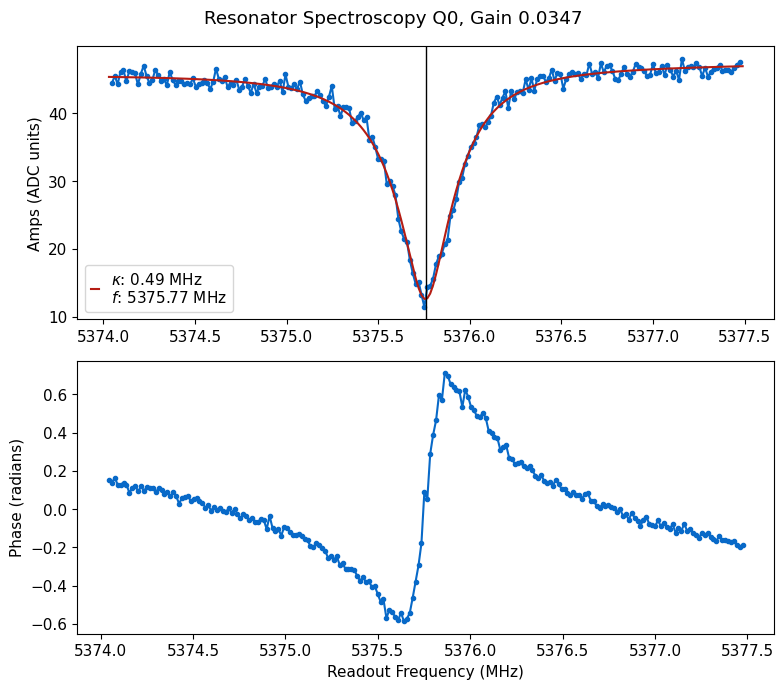

*Set cfg device.readout 0 frequency to 5375.752 from 5375.762*
*Set cfg device.readout 0 kappa to 0.4949 from 0.4949*
*Set cfg device.readout 0 qi to 4.0386 from 4.1128*
*Set cfg device.readout 0 qe to 1.4858 from 1.5053*


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

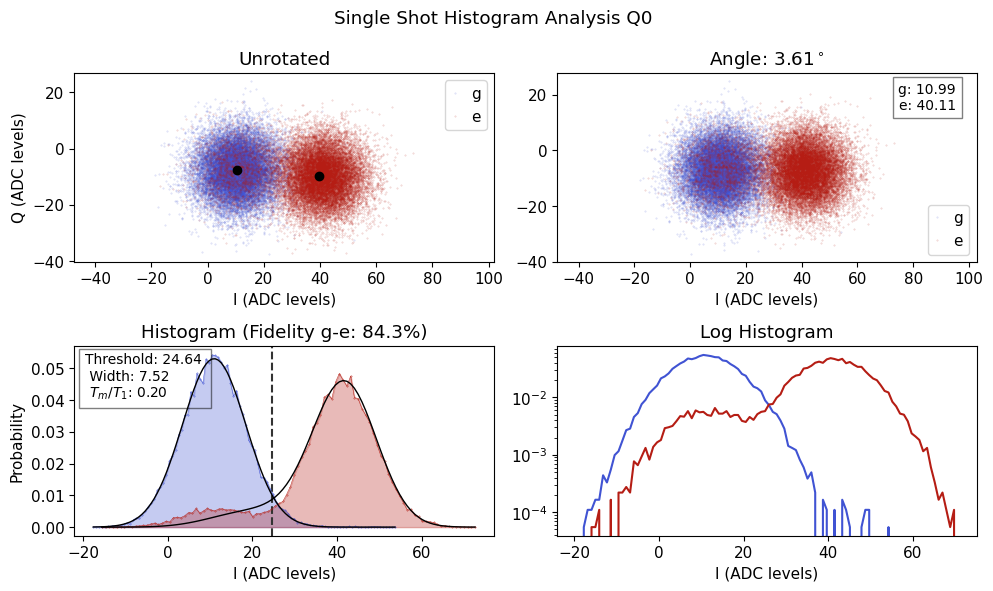

*Set cfg device.readout 0 phase to 3.605 from 133.695*
*Set cfg device.readout 0 threshold to 24.638 from 26.2953*
*Set cfg device.readout 0 fidelity to 0.8433 from 0.8214*
*Set cfg device.readout 0 sigma to 7.5169 from 7.4975*
*Set cfg device.readout 0 tm to 0.2023 from 0.0688*
*Set cfg device.qubit 0 tuned_up to True from True*


  0%|          | 0/2 [00:00<?, ?it/s]

R2:0.973	Fit par error:0.017	 Best fit:b'avgi'


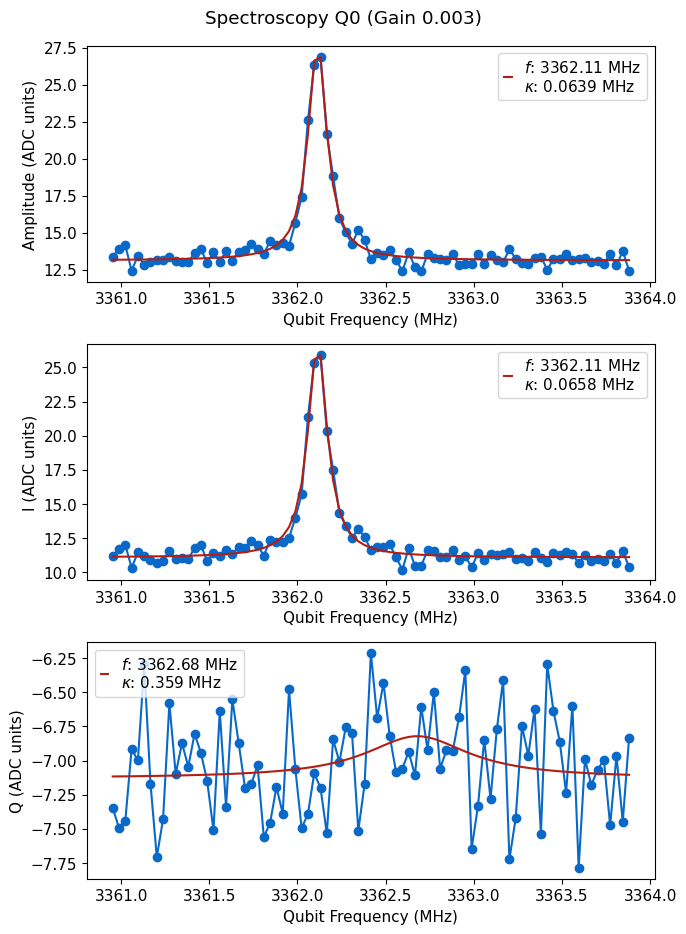

Qubit frequency is off spectroscopy by more than 250 kHz, recentering
*Set cfg device.qubit 0 f_ge to 3362.1142 from 3362.4165*


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.979	Fit par error:0.010	 Best fit:b'avgi'


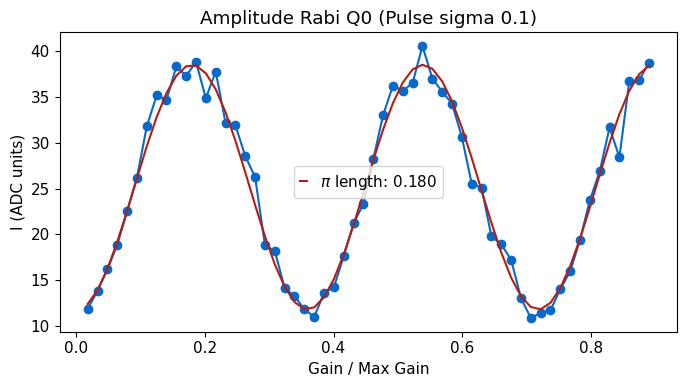

*Set cfg device.qubit 0 ('pulses', 'pi_ge', 'gain') to 0.1802 from 0.1812*
Try 0


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.850	Fit par error:0.035	 Best fit:b'avgi'


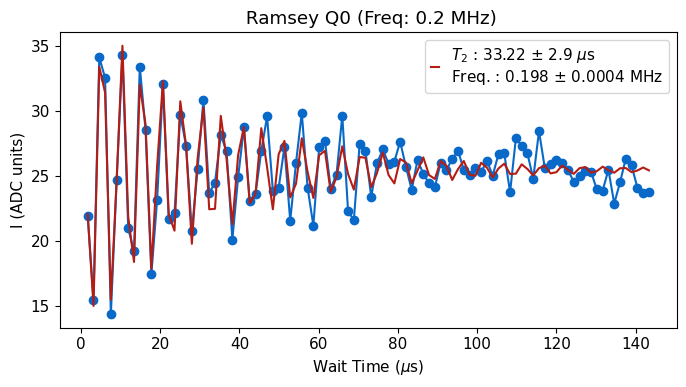

Scan successful. New frequency error is 0.002 MHz
*Set cfg device.qubit 0 f_ge to 3362.1166 from 3362.1142*
*Set cfg device.qubit 0 T2r to 33.2168 from 48.2*
Total Change in frequency: 0.002 MHz
[0.0023718173812307952]
Qubit 0 recentered from 3362.1142 to 3362.1166


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.976	Fit par error:0.015	 Best fit:b'avgi'


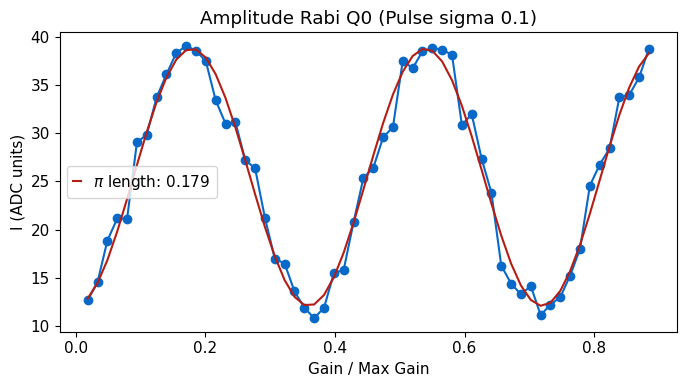

*Set cfg device.qubit 0 ('pulses', 'pi_ge', 'gain') to 0.1788 from 0.1802*


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

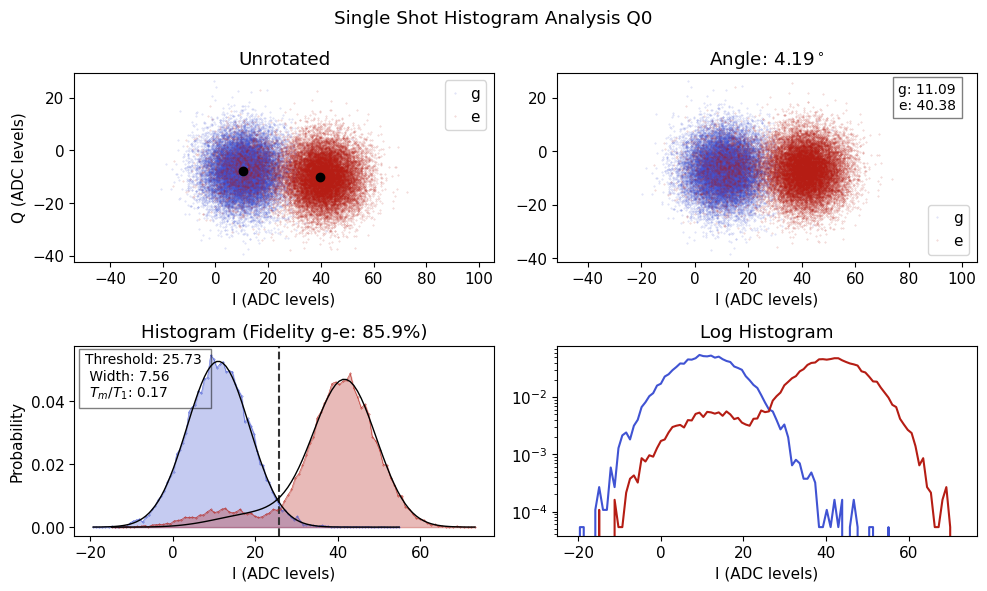

*Set cfg device.readout 0 phase to 4.1908 from 3.605*
*Set cfg device.readout 0 threshold to 25.7332 from 24.638*
*Set cfg device.readout 0 fidelity to 0.8593 from 0.8433*
*Set cfg device.readout 0 sigma to 7.5603 from 7.5169*
*Set cfg device.readout 0 tm to 0.1667 from 0.2023*
*Set cfg device.qubit 0 tuned_up to True from True*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.965	Fit par error:0.029	 Best fit:b'avgi'


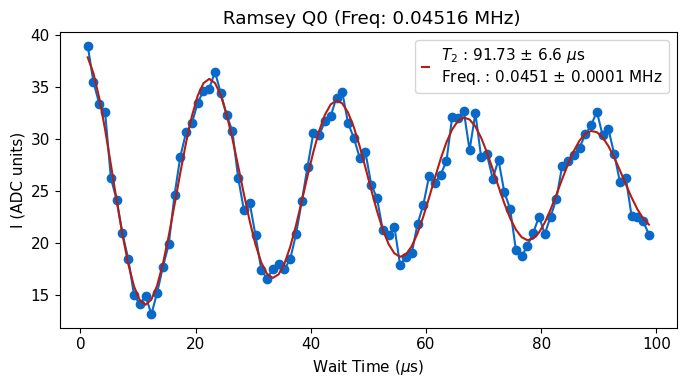

*Set cfg device.qubit 0 T2r to 91.73 from 33.2168*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.727	Fit par error:0.080	 Best fit:b'avgi'


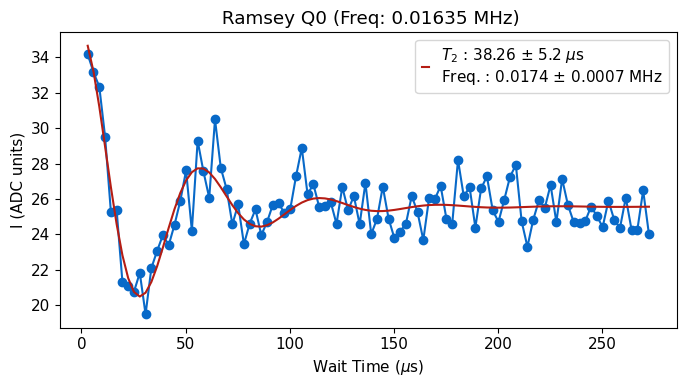

*Set cfg device.qubit 0 T2r to 38.26 from 91.73*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.889	Fit par error:0.038	 Best fit:b'avgi'


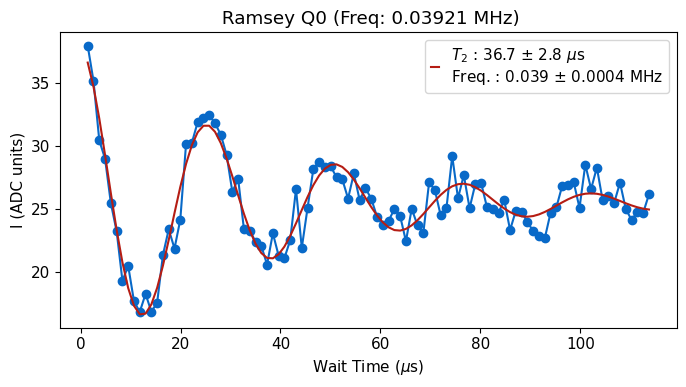

*Set cfg device.qubit 0 T2r to 36.7 from 38.26*


  0%|          | 0/12000 [00:00<?, ?it/s]

R2:0.979	Fit par error:0.035	 Best fit:b'avgi'


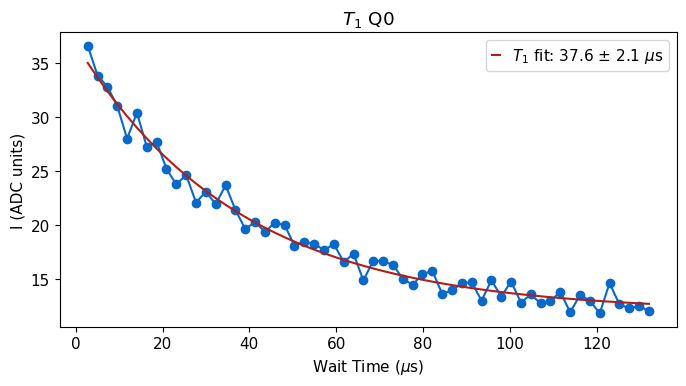

*Set cfg device.qubit 0 T1 to 37.62 from 36.17*
*Set cfg device.readout 0 final_delay to 225.71 from 217.0*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.829	Fit par error:0.052	 Best fit:b'avgi'


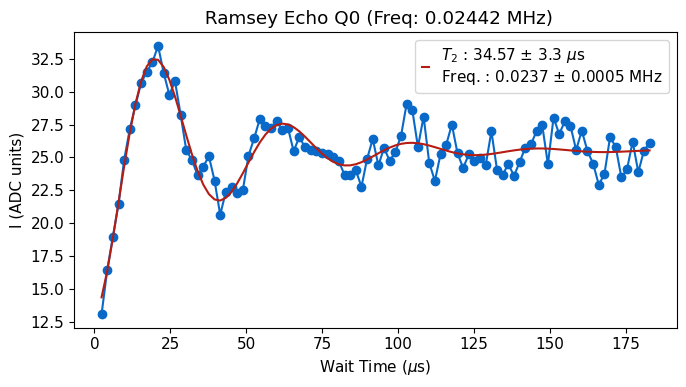

*Set cfg device.qubit 0 T2e to 34.57 from 61.43*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.889	Fit par error:0.033	 Best fit:b'avgi'


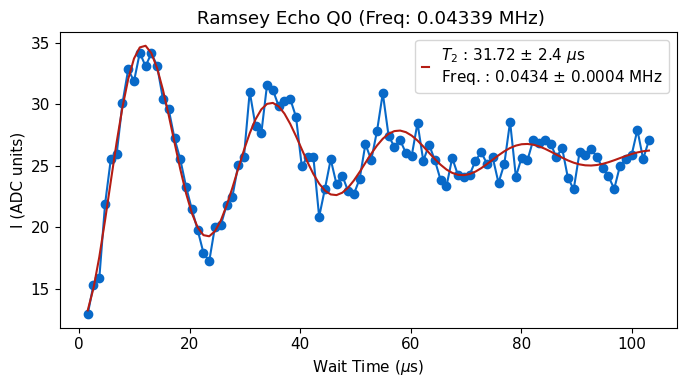

*Set cfg device.qubit 0 T2e to 31.72 from 34.57*


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

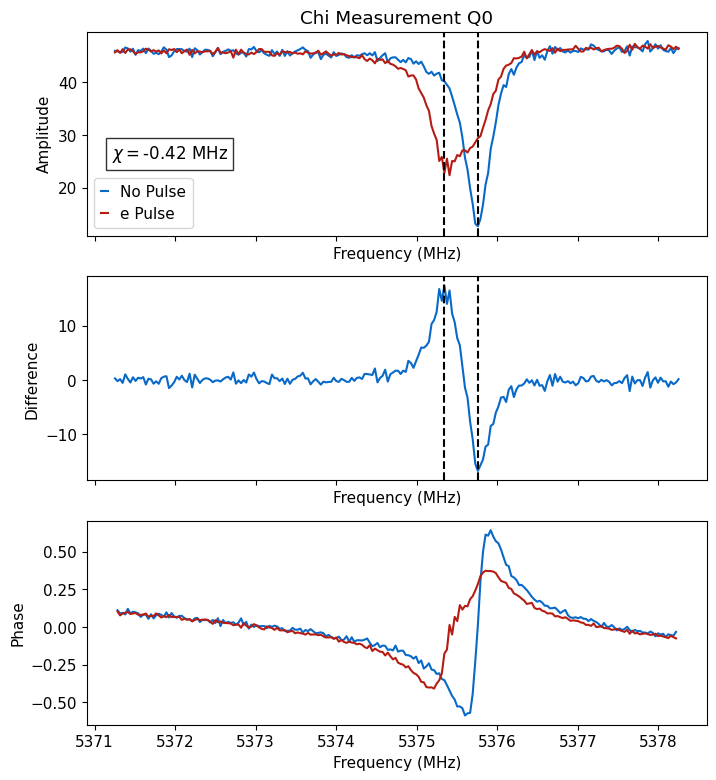

*Set cfg device.readout 0 chi to -0.4154 from -0.4154*


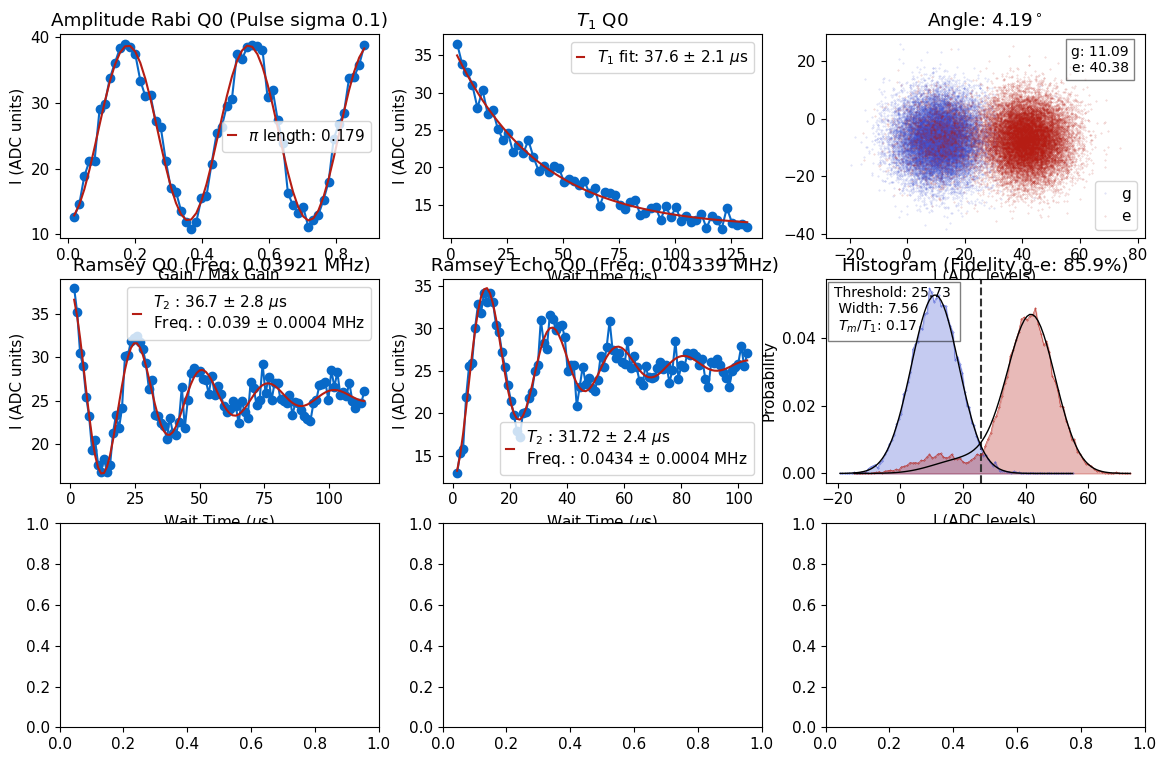

C:\_Data\Lairon\2025_06_02\images\summary\qubit0_tuneup_20250603_0825.png


In [9]:
qubit_list = np.arange(1)
#qubit_list=[1]

#qubit_list=np.delete(qubit_list, [5,13])
# Worst issue with this right now is when the qubit frequency is not correct and readout is bad; gets stuck doing ramsey/spectroscopy forever. In this case, cancel it and go back to find qubits, try changing readout gain. 
plt.rcParams.update({'font.size': 11})
for qi in qubit_list: 
    qubit_tuning.tune_up_qubit(qi, cfg_dict, first_time=False, single=False, readout=True)

## Time tracking

In [ ]:
import cProfile
import pstats
import io

scan_length = 12
cfg_dict['expt_path']=expt_path
qubit_list = np.arange(20)
bad_qubits = [0,5,13]
qubit_list = np.delete(qubit_list, bad_qubits)

qubit_list = [0,1,2]

tt=qubit_tuning.time_tracking(qubit_list, cfg_dict,display=False,total_time=scan_length, fast=True)


In [ ]:
cfg_dict['expt_path']=expt_path

In [ ]:
config.save_single_qubit_config(os.path.join('..','configs','llotsa05.yml'), 0, os.path.join('..','configs','q0.yml'))

In [ ]:
pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats()
print(s.getvalue())

In [ ]:
scan_length = 48
cfg_dict['expt_path']=expt_path
qubit_list = np.arange(20)
bad_qubits = [0,5,13]
qubit_list = np.delete(qubit_list, bad_qubits)

qubit_list = [0]

tt=qubit_tuning.time_tracking(qubit_list, cfg_dict,display=False,total_time=scan_length, fast=True)
cfg_dict['expt_path']=expt_path

## Rabi

### Amplitude

Uses gain/sigma set in pulses part of config

In [ ]:
qubit_list = np.arange(13,20)
qubit_list=[1]

update=True

for qi in qubit_list: 
    #amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi)
    
    # Fully customized version
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'num_osc':8})

    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), amp_rabi.data['pi_length'], qi)
        

#### Chevron

In [ ]:
d2=[]
qubit_list = np.arange(9)
qubit_list=[0]
for qi in qubit_list: 
    #amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'span_f':200,'sigma':0.25,'expts_f':100,'expts':100})

    amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi)
    d2.append(amp_rabi_chevron)

#handy.plot_many(d2, title='Rabi Chevron Phase', save_path=cfg_dict['expt_path'], chan='phases')

In [ ]:
handy.plot_many(d2, title='Rabi Chevron 7864', save_path=cfg_dict['expt_path'])

In [ ]:
d2[3].data['ypts']

In [ ]:
amp_rabi_chevron.display(plot_both=True)

#### 2 Qubit Rabi

In [ ]:
qi=[0,10]
amp_rabi = meas.Rabi_2Q(cfg_dict,qi=qi, params={'active_reset':False})

### Length -- Uses const pulses so do not use to set up pi pulses

In [ ]:
qubit_list = [2]
# This does not work with gaussian pulses due to multiplying qickparams issues -- need to fix
for qi in qubit_list: 
    # Needs to have params of sweep: length and type: const
    len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'type':'const'})

#### Chevron

In [ ]:
qubit_list = np.arange(20)
qubit_list=[2]
for qi in qubit_list: 
    len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.605, 'span_f':20})
    #len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.205, 'expts_f':60, 'span_f':150, 'gain':0.4,'start_f':6280,'soft_avgs':4})

## Ramsey

In [ ]:
qubit_list=[1]
update = True
for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10)

    # Manually configured
    #t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10, params = {'ramsey_freq':0.2,'expts':100, 'span':35,'start':0.01})
    if t2r.status and update:
        config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi)
        auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')

### Use Ramsey to recenter

In [ ]:
qubit_list = [2]
for qi in qubit_list:
    status = qubit_tuning.recenter(qi,cfg_dict)            

### Ramsey coherence

In [ ]:
t1= qubit_tuning.get_coherence(meas.RamseyExperiment, qi, cfg_dict,par='T2r')

## T1

In [ ]:
# If it's the first time, also set T2r and T2e as guesses 
update=True
first_time=False

qubit_list = np.arange(11,20)
qubit_list=[1]
for qi in qubit_list:
    t1 = meas.T1Experiment(cfg_dict, qi=qi)
    if update: t1.update(cfg_path, first_time=first_time)

### T1 coherence

Runs scan until scan is properly configured to be sensitive to T1

In [ ]:
qi=0
qubit_tuning.get_coherence(meas.T1Experiment,qi=qi,cfg_dict=cfg_dict,par='T1')

### Continuous scan at single point

In [ ]:
qi=0
meas.T1ContExperiment(cfg_dict,qi=qi, params={'shots':40000})

### T1 continuous 2Q

In [ ]:
qi = [10,0]
meas.T1_2Q(cfg_dict,qi=qi, )

In [ ]:
qi=[0,10]
scan_time = 0.1 #hours
number_of_scans = 1
shots = int(100000*scan_time*60/4)
print(shots)
for i in range(number_of_scans):
    meas.T1Cont2QExperiment(cfg_dict,qi=qi, params={'shots':shots, 'active_reset':False})


## Echo

In [ ]:
qubit_list = np.arange(20)
qubit_list=[1]
update=True
for qi in qubit_list:
    # Need to have experiment type set to echo
    t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'echo'})
    if t2e.status and update:
        auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['best_fit'][3], qi,sig=2, rng_vals=[1.5, max_t1*2])

### More pi

  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.697	Fit par error:0.087	 Best fit:b'avgi'


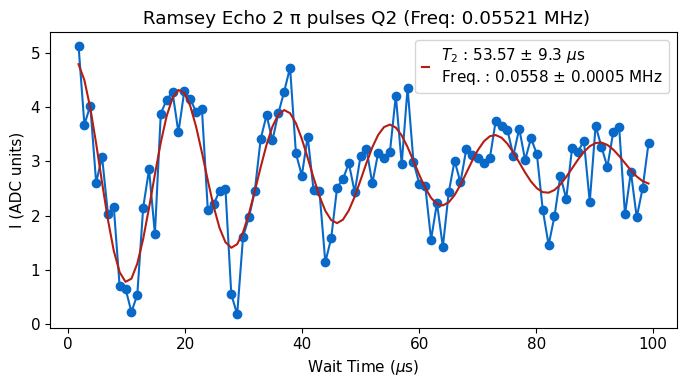

  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.669	Fit par error:0.070	 Best fit:b'avgi'


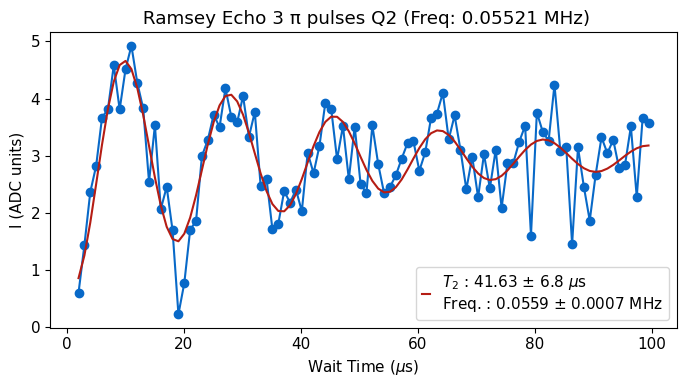

  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.722	Fit par error:0.090	 Best fit:b'avgi'


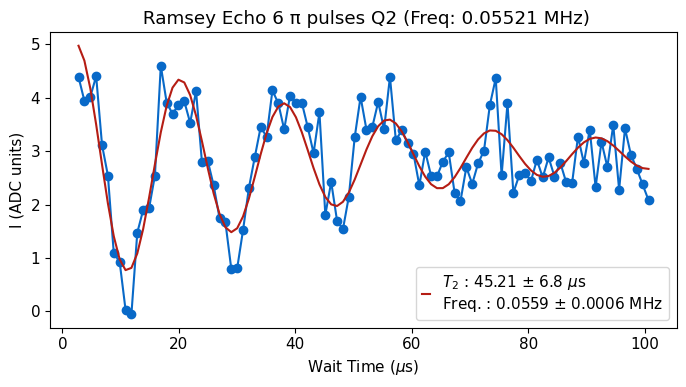

  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.659	Fit par error:0.083	 Best fit:b'avgi'


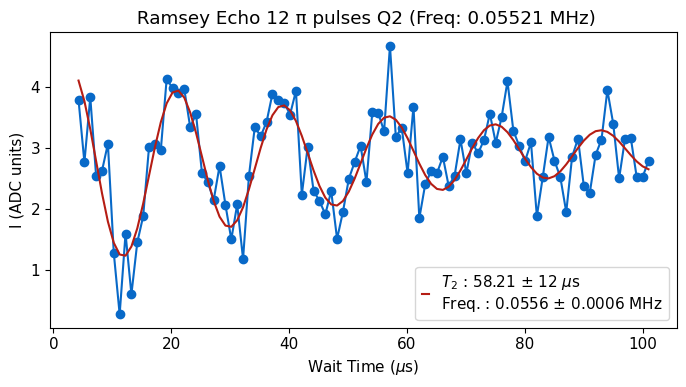

In [19]:
qubit_list = np.arange(20)
qubit_list=[2]
update=True
nums_pi = [2,3,6,12]
for qi in qubit_list:
    for pi in nums_pi:
        # Need to have experiment type set to echo
        t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'echo','num_pi':pi,'span':100})


### Get echo coherence

In [ ]:
qi=6
t2e = qubit_tuning.get_coherence(meas.RamseyEchoExperiment, qi, cfg_dict,'T2e')

## Feedback checks

In [ ]:
qi=10
reset = meas.MemoryExperiment(cfg_dict, qi=qi, params={'shots':1, 'expts':200})

In [ ]:
# Don't do the active reset, just do the repeated measurement 
qi=1
shot = meas.RepMeasExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
shot.check_reset()

# Single Shot

In [ ]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[1,2]

for qi in qubit_list:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi)

    # Configure number of shots
    #shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':300000})
    shot.update(cfg_path)
    

## Readout opt

### General sweep

Runs single shot experiments for many readout lengths, frequencies, gains and compares fidelity

In [ ]:

update=True
# Chooses lowest gain/readout length within a few percent of maximum gain (often readout fidelity fairly flat as a function of gain at higher gain values) 
low_gain=True

qubit_list=np.arange(14,20)
qubit_list=[1]

params = {'expts_f':1, 'expts_gain':7, 'expts_len':5}
#params = {'expts_f':10, 'expts_gain':1, 'expts_len':1}

# Specify exact ranges to use  
#params = {'expts_f':1, 'expts_gain':9, 'expts_len':9,'start_gain':0.45, 'span_gain':0.05,'start_len':2, 'span_len':5}

for qi in qubit_list: 
    # style='fine' varies parameters by 20%, style='' varies by 2x
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params=params)#, style='fine')
    shotopt.analyze(low_gain=low_gain)
    if update: shotopt.update(cfg_dict['cfg_file'])

### Run optimization until it converges

In [ ]:
qubit_list=np.arange(20)
qubit_list=[19]
params = {'expts_f':1, 'expts_gain':7, 'expts_len':7}

# do_res also runs res spec and resets readout frequency that way each round. 
qubit_tuning.meas_opt(cfg_dict, qubit_list, params, do_res=True)

### Vary trig_offset to see if it changes fidelity. 

In [ ]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[11]
trig_list = np.linspace(0.2,1,12)
fids =[]
for qi in qubit_list:
    for trig in trig_list: 
        config.update_readout(cfg_path, 'trig_offset', trig, qi);
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000, 'trigger':trig})
        fids.append(shot.data['fids'][0])
    

### Play with LO freq (when using qick for LO)

In [ ]:
auto_cfg = config.load(cfg_path)
start_freq = auto_cfg.device.readout.frequency[qi]
start_mixer = auto_cfg.hw.soc.lo.mixer_freq[qi]
rng = np.linspace(-1000,1000,11)
fids=[]
for qi in qubit_list: 
    for r in rng: 
        config.update_lo(cfg_path, 'mixer_freq', start_mixer+r, qi)
        config.update_readout(cfg_path, 'frequency', start_freq-r, qi)
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        fids.append(shot.data['fids'][0])

config.update_lo(cfg_path, 'mixer_freq', start_mixer, qi)
config.update_readout(cfg_path, 'frequency', start_freq, qi)

#### Play with LO power

In [ ]:
qi = 11
gain_vals = [0.0375,0.05] 
fids = []
for gain in gain_vals:
    config.update_lo(cfg_path, 'gain', gain, qi)
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params={'npts_f':5, 'npts_gain':5, 'npts_len':5})
    fids.append(shot.data['fids'][0])

### Adjust reps for fidelity 

In [ ]:
max_inc = 15 # dont' let it do more than 15x standard number of reps so that things don't take forever
qubit_list = [0]

auto_cfg = config.load(cfg_path)
for qi in qubit_list:
    config.update_readout(cfg_path, 'reps', 1/auto_cfg['device']['readout']['fidelity'][qi]**1.5, qi, rng_vals=[1,max_inc]);

## Active reset

### Check active reset at standard threshold

In [ ]:
# Setup reset uses the calibrated angle and runs active reset process at end, but also uses usual final_delay so that it's ok if reset not working
qubit_list = np.arange(15,20)
qubit_list=[1,2]
d=[]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
    shot.check_reset()
    #config.update_readout(cfg_path, 'reset_e', shot.data['reset_e'], qi)
    #config.update_readout(cfg_path, 'reset_g', shot.data['reset_g'], qi)
    d.append(shot)

### Sweep threshold

In [ ]:
d = []
qi=10
auto_cfg = config.load(cfg_path)
threshold = auto_cfg['device']['readout']['threshold'][qi]
thresh = np.linspace(threshold-25,threshold+25,16)
#thresh = np.linspace(threshold-10,threshold+10,6)
for t in thresh:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'threshold_v':t, 'active_reset':True,'setup_reset':True}, display=False, progress=False)
    d.append(shot)
    #shot.check_reset()
tuneup.plot_reset(d)

### Turn off active reset for all config chans

In [ ]:
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',False, qi)

### Turn on active reset for channels where it seems to be working

In [ ]:
e_success = 0.15 # Ratio of e proportion after active reset compared to before
g_vs_e = 2 # Ratio of g proportion to e proportion after active reset

auto_cfg = config.load(cfg_path)
reset_e = auto_cfg['device']['readout']['reset_e']
reset_g = auto_cfg['device']['readout']['reset_g']
result = np.array(reset_e)< e_success | np.array(reset_g)/np.array(reset_e)<g_vs_e
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',bool(result[qi]), qi)

### Check reset (plotting result of reset)

In [ ]:
qubit_list = np.arange(11,20)
qubit_list =[17]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000,'active_reset':True})
    shot.check_reset()

# Chi

In [ ]:
# Need a tuned up pi pulse for this
#for i in range(num_qubits):
qubit_list = [1]
for qi in qubit_list: 
    chi, chi_val=tuneup.check_chi(cfg_dict, qi)
    auto_cfg = config.update_readout(cfg_path, 'chi', chi_val, qi)


# 2 Qubit

In [ ]:
t12q = meas.T1_2Q(cfg_dict, qi=[10,0], params={'active_reset':False, })

In [ ]:
rabi2q = meas.Rabi_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

# EF 

### Initial setting of frequencies based on guess for alpha

In [ ]:
# Initial set of the frequencyies based on guess for alpha 
alpha = -150
#qubit_list = np.arange(3)
qubit_list = [1,2]
auto_cfg = config.load(cfg_path)
for i in qubit_list: 
    f_ge = auto_cfg['device']['qubit']['f_ge'][i]
    auto_cfg = config.update_qubit(cfg_path, 'f_ef', f_ge+alpha, i)

## Spectroscopy EF

### General search

Performing fine scan


  0%|          | 0/100000 [00:00<?, ?it/s]

R2:0.903	Fit par error:0.028	 Best fit:b'avgi'


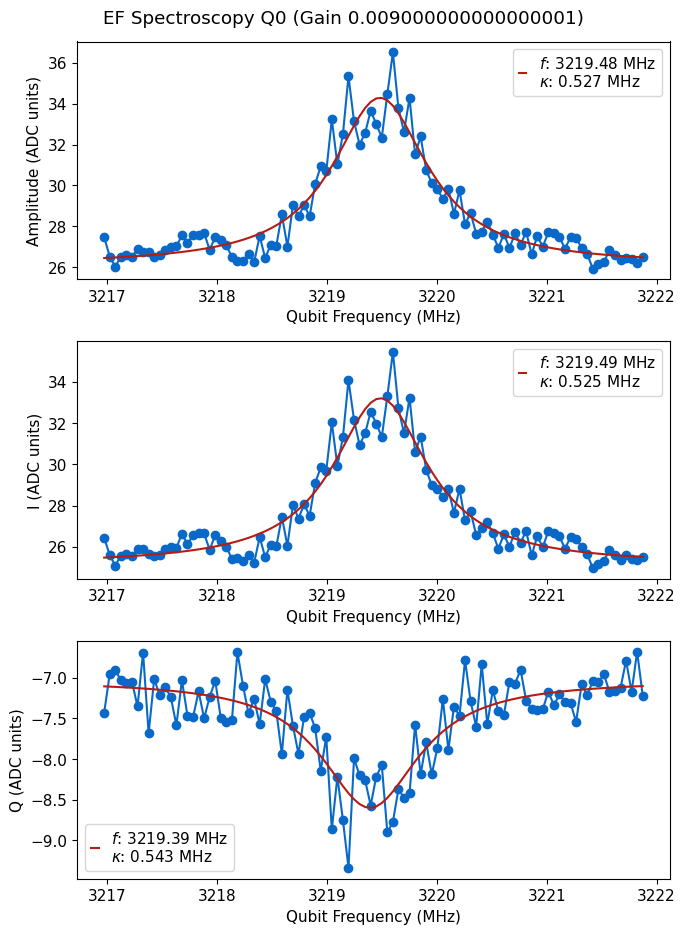

*Set cfg device.qubit 0 f_ef to 3219.4876 from 3219.4244*
Found qubit 0
Performing fine scan


  0%|          | 0/100000 [00:00<?, ?it/s]

R2:0.918	Fit par error:0.026	 Best fit:b'amps'


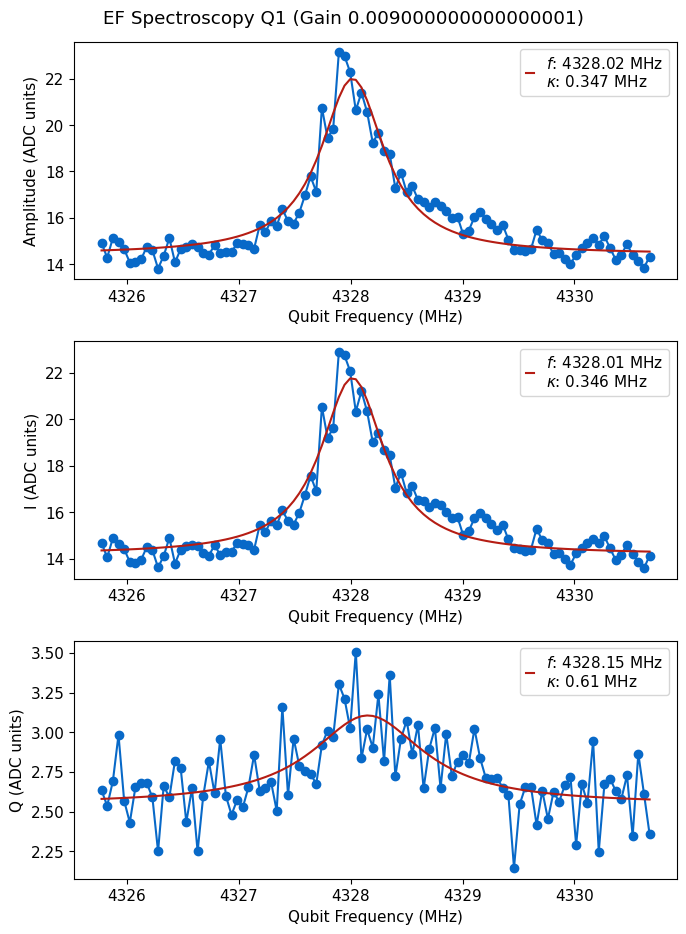

*Set cfg device.qubit 1 f_ef to 4328.0154 from 4328.222*
Found qubit 1
Performing fine scan


  0%|          | 0/100000 [00:00<?, ?it/s]

R2:0.873	Fit par error:0.033	 Best fit:b'amps'


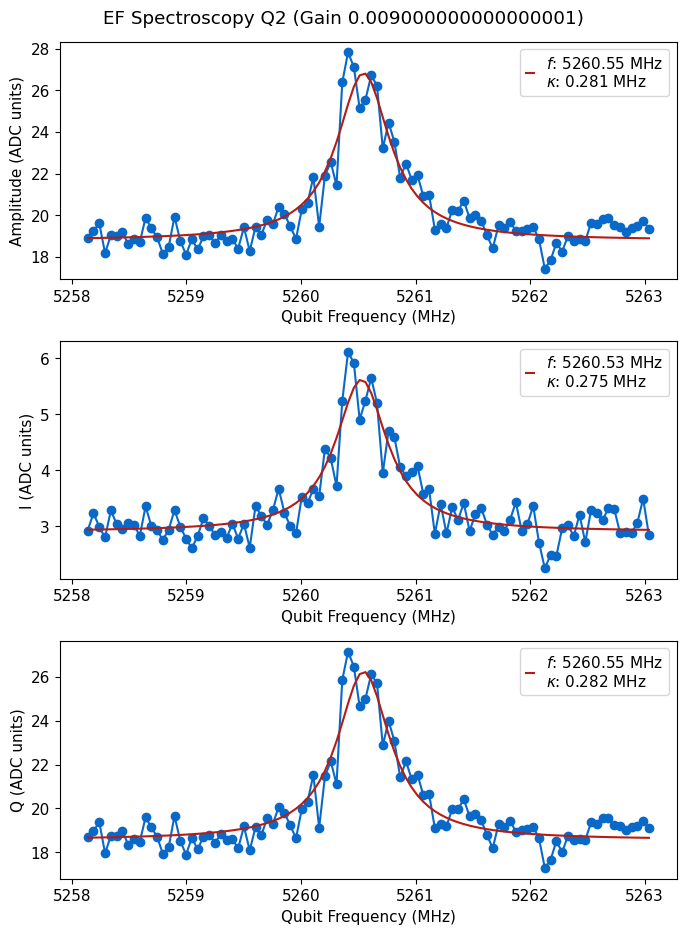

*Set cfg device.qubit 2 f_ef to 5260.5458 from 5260.5881*
Found qubit 2


In [14]:
qubit_list= np.arange(3)
bad_qubits=[]
#qubit_list=[2]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='fine', freq='ef')
    if not status:
        bad_qubits.append(qi)

### Specific width

In [ ]:
# You may want to update this frequency, which will be the center of the scan. 
#style huge, coarse, medium, fine 
update=True

qubit_list = np.arange(10)
qubit_list=[2]
for qi in qubit_list:
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params={'checkEF':True, 'gain':1,'reps':2000})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})

    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})
    if update and qspec.status:
        auto_cfg = config.update_qubit(cfg_path, 'f_ef', qspec.data["best_fit"][2], qi)

## Rabi EF

  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.868	Fit par error:0.024	 Best fit:b'avgi'


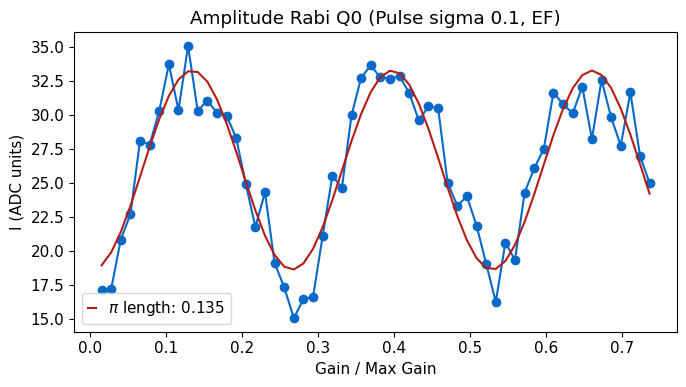

*Set cfg device.qubit 0 ('pulses', 'pi_ef', 'gain') to 0.1347 from 0.15*


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.859	Fit par error:0.030	 Best fit:b'avgi'


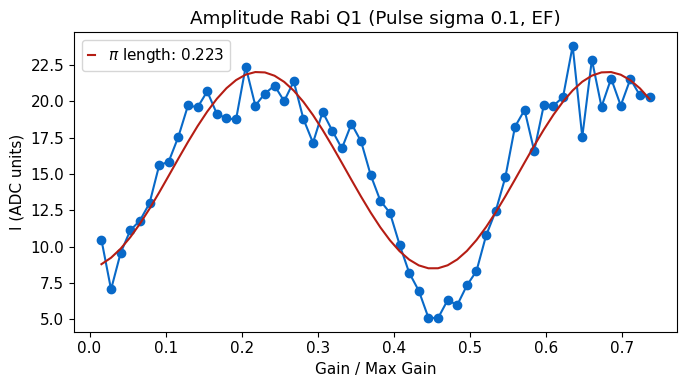

*Set cfg device.qubit 1 ('pulses', 'pi_ef', 'gain') to 0.2225 from 0.15*


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.916	Fit par error:0.023	 Best fit:b'avgi'


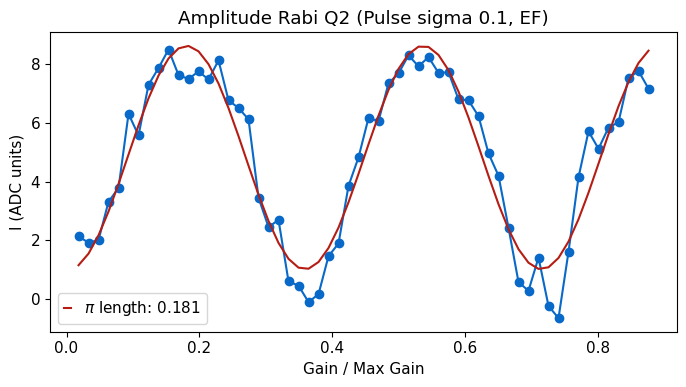

*Set cfg device.qubit 2 ('pulses', 'pi_ef', 'gain') to 0.1807 from 0.1784*


In [15]:
# If first time, initialize the sigma and gain to those of the ge 
first_time =False
update = True

qubit_list = np.arange(3)
#qubit_list=[2]

bad_qubits = []
auto_cfg = config.load(cfg_path)

for qi in qubit_list: 
    if first_time:
        #config.update_qubit(cfg_path, 'f_ef', auto_cfg.device.qubit.f_spec_ef[qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','sigma'), auto_cfg['device']['qubit']['pulses']['pi_ge']['sigma'][qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), auto_cfg['device']['qubit']['pulses']['pi_ge']['gain'][qi], qi)
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'checkEF':True})
    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), amp_rabi.data['pi_length'], qi)
    else:
        print(f'Amplitude Rabi fit failed for qubit {qi}')
        bad_qubits.append(qi)

## Qubit Temperature

  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.860	Fit par error:0.026	 Best fit:b'avgi'


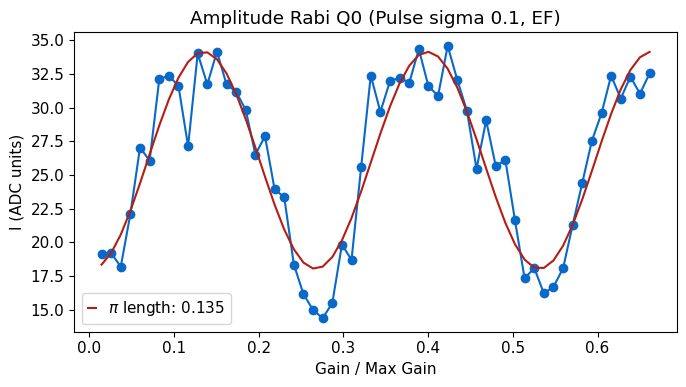

  0%|          | 0/20 [00:00<?, ?it/s]

R2:0.494	Fit par error:0.153	 Best fit:b'avgi'


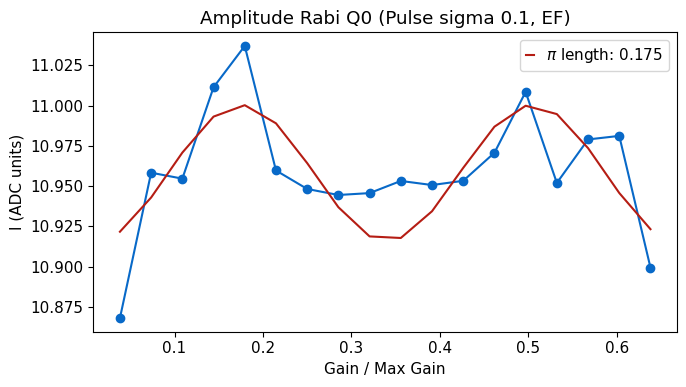

Qubit temp [mK]: 30.737568535968855
State preparation ratio: 0.005250265451678275
8.045847417968108
0.042242834728032815


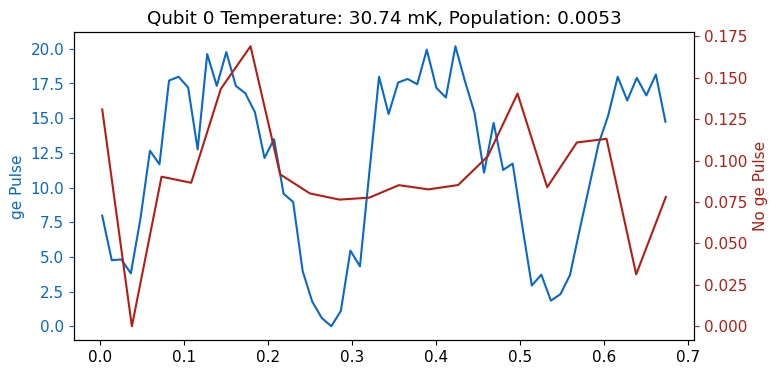

*Set cfg device.qubit 0 temp to 30.7376 from 0*
*Set cfg device.qubit 0 pop to 0.0053 from 0*


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.886	Fit par error:0.036	 Best fit:b'avgi'


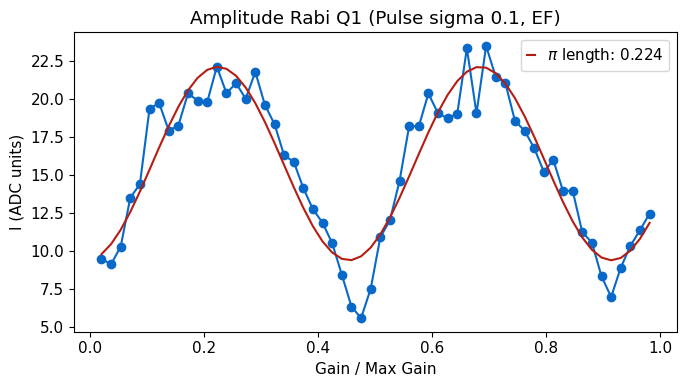

  0%|          | 0/20 [00:00<?, ?it/s]

R2:0.524	Fit par error:0.151	 Best fit:b'avgi'


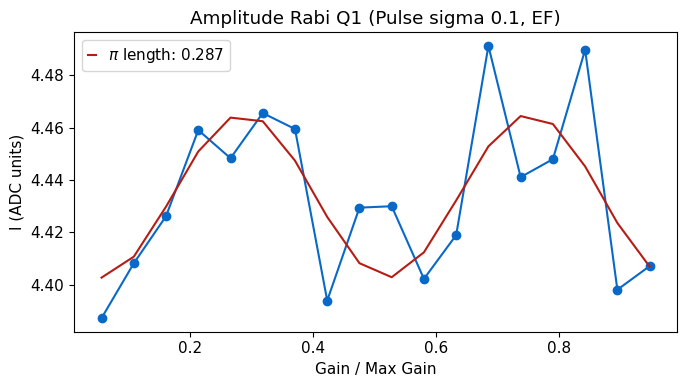

Qubit temp [mK]: 41.062385828763034
State preparation ratio: 0.004904712444590624
6.363756076300634
0.031212393621770917


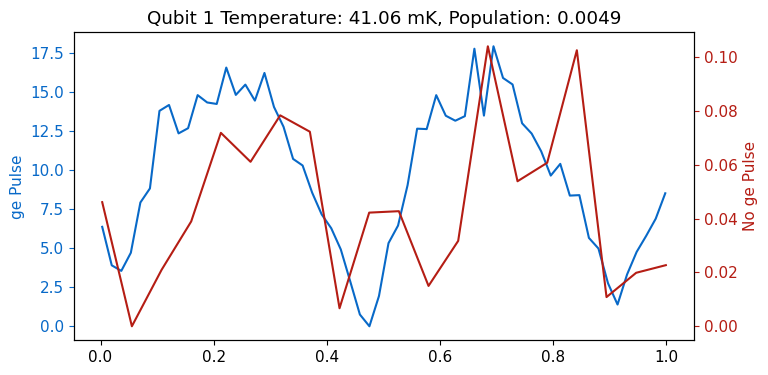

*Set cfg device.qubit 1 temp to 41.0624 from 0*
*Set cfg device.qubit 1 pop to 0.0049 from 0*


  0%|          | 0/6000 [00:00<?, ?it/s]

R2:0.935	Fit par error:0.021	 Best fit:b'avgi'


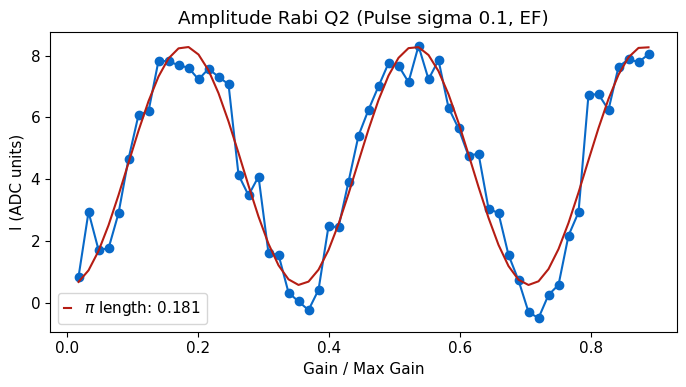

  0%|          | 0/20 [00:00<?, ?it/s]

R2:0.843	Fit par error:0.064	 Best fit:b'avgi'


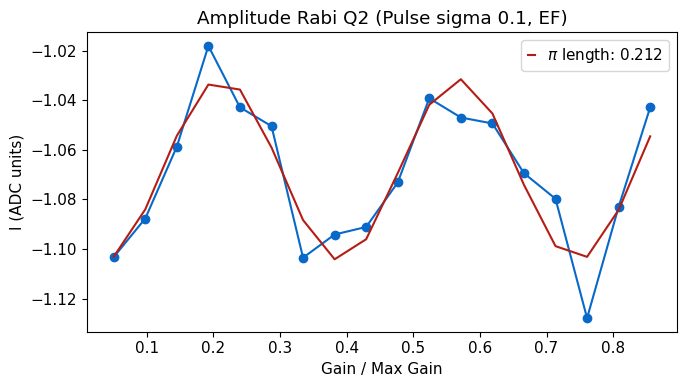

Qubit temp [mK]: 56.74104017793083
State preparation ratio: 0.009457218363785156
3.861657524718561
0.036520538457417505


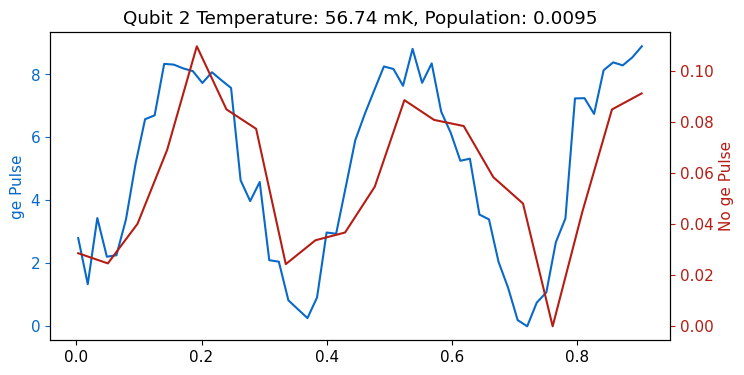

*Set cfg device.qubit 2 temp to 56.741 from 0*
*Set cfg device.qubit 2 pop to 0.0095 from 0*


In [16]:
qubit_list = np.arange(3)
#qubit_list=[0]
for qi in qubit_list: 
    # Soft_avgs will make scan take longer, needed for lower temperatures. 
    temp, pop = tuneup.measure_temp(cfg_dict, qi=qi)# , soft_avgs=5)
    auto_cfg = config.update_qubit(cfg_path, 'temp', temp, qi)
    auto_cfg = config.update_qubit(cfg_path, 'pop', pop, qi)

In [ ]:
auto_cfg = config.load(cfg_path)
import scqubits as scq
for i in np.arange(3):
    alpha =  auto_cfg.device.qubit.f_ef[i] - auto_cfg.device.qubit.f_ge[i]
    en = scq.Transmon.find_EJ_EC(auto_cfg.device.qubit.f_ge[i]/1000,alpha/1000)
    print(alpha)
    print(en)
    q = np.pi*2 * auto_cfg.device.qubit.f_ge[i] * auto_cfg.device.qubit.T1[i]
    print(q)

## Ramsey EF

  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.736	Fit par error:355287.213	 Best fit:b'avgi'
R2:0.736	Fit par error:19.504	 Best fit:b'avgi'


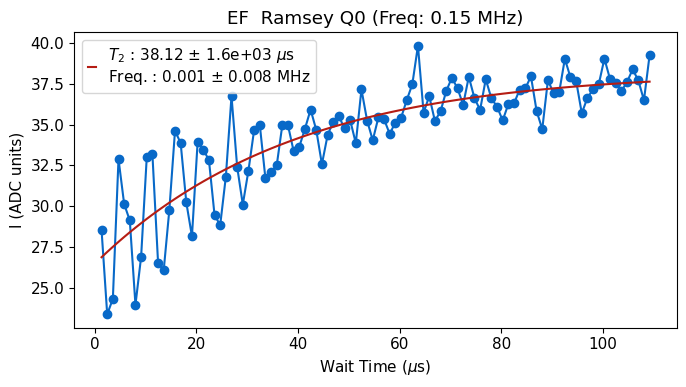

T2 Ramsey fit failed


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:nan	Fit par error:nan	 Best fit:b'avgi'
R2:0.937	Fit par error:0.838	 Best fit:b'avgi'


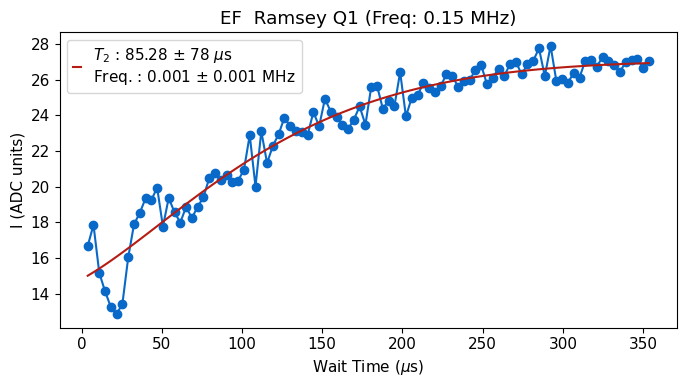

*Set cfg device.qubit 1 f_ef to 4328.222 from 4328.073*


  0%|          | 0/20000 [00:00<?, ?it/s]

R2:0.582	Fit par error:1043469.386	 Best fit:b'avgi'
R2:0.582	Fit par error:41.999	 Best fit:b'avgi'


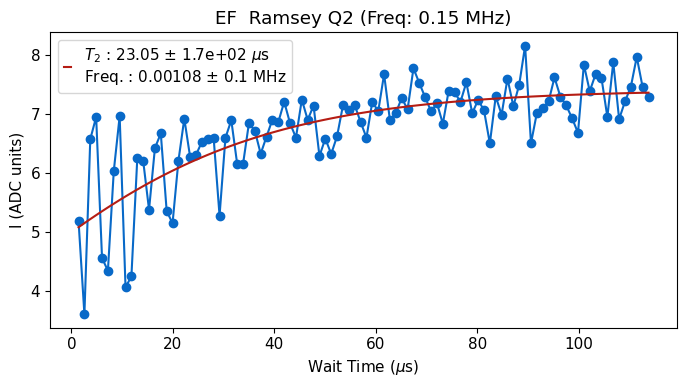

T2 Ramsey fit failed


In [13]:
update=True
qubit_list=np.arange(3)
#qubit_list=[12]

for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, params={'ramsey_freq':0.15, 'checkEF':True})

    if update and t2r.status:
        config.update_qubit(cfg_path, 'f_ef', t2r.data['new_freq'], qi)
    else:
        print('T2 Ramsey fit failed')

# Stark

## Ramsey

### Single experiment

In [ ]:
qi=10
meas.RamseyStarkExperiment(cfg_dict, qi=qi, params={'stark_gain':0.0,'step':0.1,'df':200,'acStark':False,'ramsey_freq':0.1})

### Sweep frequency

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[3]
gain = np.linspace(0.1,1,10)
for qi in qubit_list:
    for g in gain:
        t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':g, 'start_df':30, 'end_df':150, 'expts_df':10})

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[17]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':0.1, 'start_df':20, 'end_df':100, 'expts_df':40})

### Calibrate stark power positive freq

In [ ]:
qubit_list = np.arange(13,20)
qubit_list=[19]
d=[]
freqs= [200]
for f in freqs:
    for qi in qubit_list:
        t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':f, 'start_gain':0.1, 'end_gain':1})
        d.append(t2rstark)
        config.update_stark(cfg_path, 'q', t2rstark.data['quad_fit'][0], qi)
        config.update_stark(cfg_path, 'l', t2rstark.data['quad_fit'][1], qi)
        config.update_stark(cfg_path, 'o', t2rstark.data['quad_fit'][2], qi)

In [ ]:
plt.figure()
for i in range(len(t2rstark.data['bin_centers'])):
    plt.plot(t2rstark.data['bin_centers'][i], t2rstark.data['hist'][i])

### Negative frequency

In [ ]:
#qubit_list = np.arange(20)
d=[]
qubit_list=[19]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':-100, 'start_gain':0.08, 'end_gain':0.35, 'soft_avgs':2})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'qneg', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'lneg', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'oneg', t2rstark.data['quad_fit'][2], qi)
#handy.plot_many(d, title='Ramsey Stark', save_path=cfg_dict['expt_path'])

## T1

### Single exp

In [ ]:
qi=19
gain_list = [0.5,0.6,0.77]
for g in gain_list:
    t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':g,'expts':300,'span':10}) 

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':10}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':10}) 
t1x = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':5}) 
t1y = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':5}) 
t13 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':0.05}) 
t14 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7, 'end_wait':0.05}) 

plt.plot(t1.data['bin_centers'], t1.data['hist'], 'r')
plt.plot(t12.data['bin_centers'], t12.data['hist'],'r')

plt.plot(t1x.data['bin_centers'], t12.data['hist'],'g')
plt.plot(t1y.data['bin_centers'], t12.data['hist'],'g')

plt.plot(t13.data['bin_centers'], t13.data['hist'],'b')
plt.plot(t14.data['bin_centers'], t14.data['hist'],'b')

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7}) 
plt.plot(t1.data['bin_centers'], t1.data['hist'])
plt.plot(t12.data['bin_centers'], t12.data['hist'])

### Gain sweep

In [ ]:
qubit_list = np.arange(12,20)
qubit_list=[19]
flist=[210,180]
for f in flist:
    for qi in qubit_list: 
        #t1_neg = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':-70,'start_gain':0.02,'end_gain':0.2,'start':3, 'soft_avgs':4})

        t1_pos = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':f,'start_gain':0.3,'end_gain':1,'start':0.2, 'soft_avgs':1,'span':0.5,'expts_gain':80}) #, 'start':100,'span':0.34, 'expts':100, 'soft_avgs':3})
        plt.figure()
        for i in range(len(t1_pos.data['bin_centers'])):
            plt.plot(t1_pos.data['bin_centers'][i], t1_pos.data['hist'][i])

### Freq sweep

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100})

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100,'gain':0.5})

### Single evo point linear gain sweep

In [ ]:
t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=0, params={"soft_avgs":4})

### Run linear scan for multiple qubits

In [ ]:
#first, need to configure active reset and check stark for all. 
nexp = 3
qubit_list =[1,2]#2,4,5,6,7]
expts = 200
t1_data = [[] for _ in qubit_list]

for i in range(nexp):
    for j, qi in enumerate(qubit_list):
        t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=qi, params={ "soft_avgs":2,'expts':100})
        t1_data[j].append(t1_cont.data['t1'])

plt.figure()
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])

### Repeated single evo, sweep frequency linearly with gain [Main scan]

In [ ]:
d=[]
qi=6
params={'stop_f':20, 'df_pos':100, 'df_neg':-70}
for i in range(200):
    if i%10==0:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params)
        shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        config.update_readout(cfg_path, 'threshold',shot.data['thresholds'][0], qi);
        config.update_readout(cfg_path, 'phase', shot.data['angle'], qi);
        phase.append(shot.data['angle'])
    else:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params, display=False, progress=False)

    d.append(t1stark)

times = [d[i].data['start_time'] for i in range(0, len(d))] 
tm = [datetime.strptime(times[i].decode('utf-8'), '%Y-%m-%d %H:%M:%S') for i in range(len(times))]
time_from_first = [(t - tm[0]).total_seconds() for t in tm]
print(time_from_first)

concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)

plt.figure()
plt.pcolormesh(concatenated_data)

In [ ]:
plt.figure()
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)
import matplotlib.dates as mdates

plt.pcolormesh(np.array(time_from_first)/60/60, d[-1].data['f_pts'], concatenated_data)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.gcf().autofmt_xdate()


### Calib sweep

### Analysis of multiple evo times using normal fittingh

In [ ]:
# Processing for multiple evo times 
cd0 = np.concatenate([d[i].data['avgi_0'] for i in range(0, len(d))], axis=1)
cd1 = np.concatenate([d[i].data['avgi_1'] for i in range(0, len(d))], axis=1)
cd2 = np.concatenate([d[i].data['avgi_2'] for i in range(0, len(d))], axis=1)
cd3 = np.concatenate([d[i].data['avgi_3'] for i in range(0, len(d))], axis=1)

combined_cd = np.stack((cd0, cd1, cd2, cd3), axis=-1)
print(combined_cd.shape)

tms=d[0].data['wait_times']

sns.set_palette('coolwarm',len(combined_cd))
from scipy.optimize import curve_fit
plt.figure()
def t1_fit(x, a, b, c):
    return b * np.exp(-x / c) + a
fits=[]
tm_full = np.linspace(0, tms[3])
#for i in range(5):
for i in range(len(combined_cd)):
    plt.plot(tms, combined_cd[i][0][:],'o-')
    p0 = (np.min(combined_cd[i][0][:]), np.max(combined_cd[i][0][:])-np.min(combined_cd[i][0][:]), tms[2])
    popt, err = curve_fit(t1_fit, tms, combined_cd[i][0][:], p0=p0)
    fit_err = np.sqrt(np.diag(err))   
    if np.mean(fit_err/np.abs(popt))>0.5:
        fits.append(np.nan*np.ones(3))   
    else:
        fits.append(popt)
    #print(p0)
    #plt.plot(tm_full, t1_fit(np.array(tm_full), *popt),'k', label=f'Fit {i}')
    #print(popt)
#plt.legend()
t1_data = [fits[i][2] for i in range(len(fits))]    
offset = [fits[i][0] for i in range(len(fits))]
amp = [fits[i][1] for i in range(len(fits))]

fig, ax = plt.subplots(3, 1, figsize=(8, 7))
ax[0].plot(t1_data, 'o-')
ax[1].plot(offset, 'o-')
ax[2].plot(amp, 'o-')

In [ ]:
# Concatenate all d[i].data['avgi'] into a single dataset
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

#### Check max value for calibration

In [ ]:
np.max(t1.data['avgi'], axis=1)
plt.figure()
plt.plot(np.max(t1.data['avgi'], axis=1))